# Nowcast Analysis Notebook
This notebook demonstrates the process of loading and analyzing long (6+ month) timeseries of SalishSeaCast Nowcast (or Hindcast) results.

The analysis is organized into the following sections:

   1. [Load Results](#Load-Results)
   2. [Postprocessing](#Postprocessing)
   3. [Wind Averaging](#Wind-Averaging)
   4. Spectral Coherence
   5. [Principal Component Analysis](#Principal-Component-Analysis)
   6. Canonical Correlation Analysis

In [11]:
from salishsea_tools import timeseries_tools, viz_tools, grid_tools, tidetools
from importlib import reload
from matplotlib import gridspec, dates
from collections import OrderedDict
from scipy import io
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import timeseries_extras
import pickle

%matplotlib inline

## Load Results
Most of the machinery to load the results is compartmentalized into the `salishsea_tools.timeseries_tools` module. These tools load the results in 24 hour chunks, extracting, flattening, and trimming the requested fields in order to conserve memory and minimize computational expense. Even so, long timeseries of several variables and sections will take hours to load on `salish`.

Load grid and mask files.

In [3]:
# Load mask and grid
mask = xr.open_dataset('/data/bmoorema/MEOPAR/NEMO-forcing/grid/mesh_mask_downbyone2.nc')
grid = xr.open_dataset('/data/bmoorema/MEOPAR/NEMO-forcing/grid/bathy_downonegrid2.nc')
grid_GEM = xr.open_dataset('/results/forcing/atmospheric/GEM2.5/operational/ops_y2017m01d01.nc')

Build GEM mask

In [4]:
# Build GEM mask
mask_GEM = grid_tools.build_GEM_mask(grid_GEM, grid, mask.tmask.isel(t=0, z=0))

Building GEM mask 100% (68096 of 68096) |###################################|Time: 0:04:17


Specify time range (start at `00:00` and end at `23:00`)

In [18]:
# Timerange
timerange = ['2017 Jan 1 00:00', '2017 Jan 31 23:00']

Load, flatten, and trim GEM record from ERDDAP. This step is mostly `xarray` but uses the GEM-specific `reshape_coords_GEM()` function and the more generic `reshape_to_ts()` function.

In [6]:
# Load GEM record
GEM_in = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
GEM = timeseries_extras.reshape_GEM(GEM_in.sel(time=slice(*timerange)), grid_GEM, mask_GEM)

Load, flatten, and trim Nowcast record.

In [22]:
# Loop through requests
dims = ['depth'] #, 'depth', 'y', 'y', 'y']
indices = [0] #, 20, 450, 520, 680]
variables = ['votemper'] #, 'vosaline', 'vozocrtx', 'vomecrty']
Nowcast = timeseries_extras.iterate_NEMO_timeseries(timerange, variables, mask, dims, indices)

In [20]:
# Save output
with open('/ocean/bmoorema/research/MEOPAR/analysis-ben/data/testdata', 'wb') as fid:
    pickle.dump(Nowcast, fid)

## Postprocessing
First some basic postprocessing. Filter tides.

In [23]:
# Filter tides 
variables = ['vozocrtx', 'vomecrty']  # Just the velocities
dims = ['depth']  # Just the horizontal currents
for variable in variables:
    for dim in dims:
        for section in Nowcast[variable][dim].items():
            section[1]['filter'] = tidetools.filter_timeseries(section[1]['data'], method='doodson')

# Filter wind
GEM_flat['filter']['grid']['u'] = tidetools.filter_timeseries(GEM_flat['raw']['grid']['u'], method='doodson')
GEM_flat['filter']['grid']['v'] = tidetools.filter_timeseries(GEM_flat['raw']['grid']['v'], method='doodson')

Rotate velocities.

In [40]:
# Rotate U wind
GEM_flat['raw']['rotate']['u'], GEM_flat['raw']['rotate']['v'] = viz_tools.rotate_vel(
    GEM_flat['raw']['grid']['u'], GEM_flat['raw']['grid']['v'], origin='map')

# Rotate V wind
GEM_flat['filter']['rotate']['u'], GEM_flat['filter']['rotate']['v'] = viz_tools.rotate_vel(
    GEM_flat['filter']['grid']['u'], GEM_flat['filter']['grid']['v'], origin='map')

## Wind Averaging
Here the Nowcast fields are averaged over different periods based on the wind record. The wind record is determined by the spatially averaged alongstrait wind component.

In [41]:
# Spatially average the alongstrait wind component
wind_index = GEM_flat['raw']['rotate']['v'].mean(axis=1)
wind_index_filter = GEM_flat['filter']['rotate']['v'].mean(axis=1)

Below is the 2016 spatially averaged alongstrait wind record.

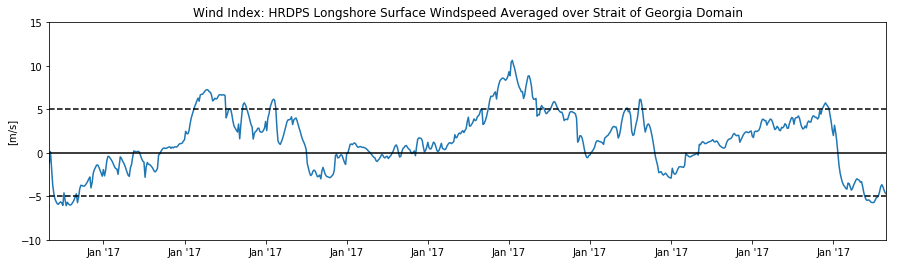

In [49]:
# Figure setup
fig, ax = plt.subplots(1, 1, figsize=(15, 4))

# Plot wind timeseries
ax.plot(GEM.time.sel(time=slice(*timerange)), wind_index)
ax.plot(GEM.time.sel(time=slice(*timerange)), np.ones(wind_index.shape)*5, 'k--')
ax.plot(GEM.time.sel(time=slice(*timerange)), np.ones(wind_index.shape)*-5, 'k--')
ax.plot(GEM.time.sel(time=slice(*timerange)), np.zeros(wind_index.shape), 'k-')
ax.set_xlim(timerange)
ax.set_ylim([-10, 15])
ax.xaxis.set_major_formatter(dates.DateFormatter("%b '%y"))
ax.set_ylabel('[m/s]')
ax.set_title('Wind Index: HRDPS Longshore Surface Windspeed Averaged over Strait of Georgia Domain')

# Save figure
fig.savefig('/ocean/bmoorema/research/MEOPAR/analysis-ben/figures/testfig1', dpi=300, bbox_inches='tight')

The averaging periods are when the alongstrait windspeed is greater than 5 m/s. Below are the Nowcast surface velocity fields.

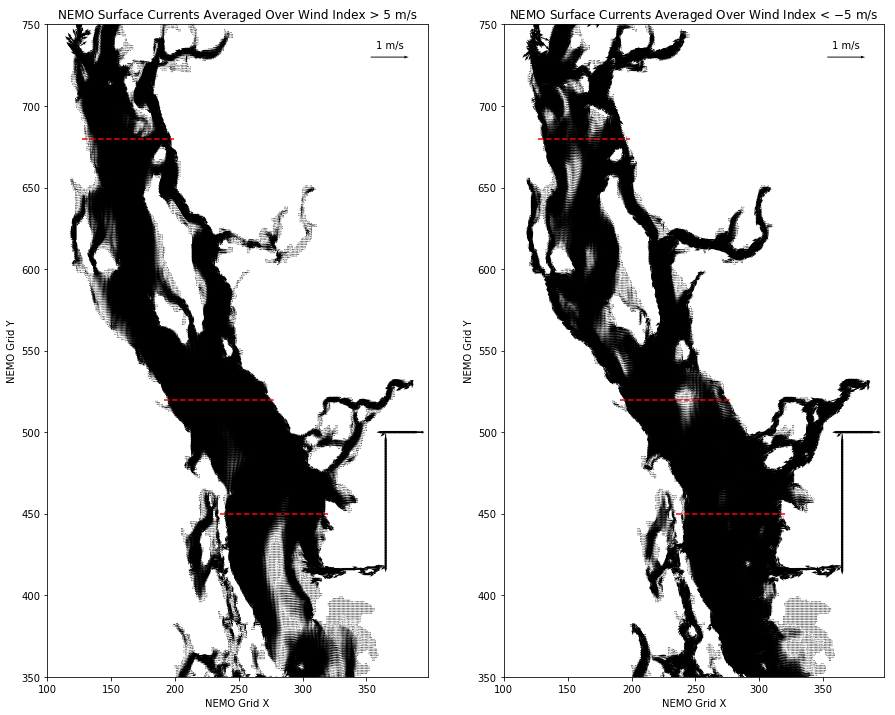

In [55]:
# Figure setup
fig, axs = plt.subplots(1, 2, figsize=(15, 12))

# Define plot list
windices = [wind_index > 5, wind_index < -5]
titles = ['> 5', '< $-$5']

# Loop through plot list
for ax, windex, title in zip(axs, windices, titles):
    Q = ax.quiver(
        Nowcast['vozocrtx']['depth'][0]['coords']['gridX'],
        Nowcast['vozocrtx']['depth'][0]['coords']['gridY'],
        Nowcast['vozocrtx']['depth'][0]['data'][windex, :].mean(axis=0),
        Nowcast['vomecrty']['depth'][0]['data'][windex, :].mean(axis=0), scale=10
    )
    viz_tools.plot_land_mask(ax, grid, color='burlywood')
    viz_tools.plot_coastline(ax, grid)
    ax.plot([127, 199], [680, 680], 'r--')  # Northern transect
    ax.plot([191, 278], [520, 520], 'r--')  # Central transect
    ax.plot([235, 320], [450, 450], 'r--')  # Southern transect
    ax.set_xlim([100, 398])
    ax.set_ylim([350, 750])
    ax.set_xlabel('NEMO Grid X')
    ax.set_ylabel('NEMO Grid Y')
    ax.set_title(f'NEMO Surface Currents Averaged Over Wind Index {title} m/s')
    plt.quiverkey(Q, 0.9, 0.95, 1, '1 m/s')

# Save figure
#fig.savefig('/ocean/bmoorema/research/MEOPAR/analysis-ben/figures/testfig2', dpi=300, bbox_inches='tight')

Below are the Nowcast density and alongstrait velocity cross sections.

In [ ]:
# Make figure and gridspec layout
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Fudge Wind Index
WINDEX = np.zeros(wind_index.shape)
WINDEX[888:] = wind_index[888:]

# Subplot array parameters
sections = OrderedDict([
    ('Fraser Plume'   , {'index': 450, 'lims': [235, 320]}),
    ('Central Strait' , {'index': 520, 'lims': [191, 278]}),
    ('Northern Strait', {'index': 450, 'lims': [127, 199]}),
])

# Loop through subplots
for section in sections.items():

    C1 = ax.contourf(gridX, deptht, V[windex, :].mean(axis=0), levels=np.arange(-0.3, 0.35, 0.05), extend='both', cmap='coolwarm')
    C2 = ax.contour(gridX, deptht, np.ma.masked_values(RHO[windex, :].mean(axis=0), 0), levels=np.arange(0, 24), colors='k')
    ax.contourf(mask.tmask.x, mask.gdept_1d.isel(t=0), mask.tmask.isel(t=0, y=sec), [-0.01, 0.01], colors='burlywood')
    ax.set_xlim(xlim)
    ax.set_ylim([0, 50])
    ax.invert_yaxis()
    plt.clabel(C2, fmt='%.1f')
    ax.set_ylabel('Depth [m]')
    ax.set_xlabel('NEMO gridX')
    ax.set_title(f'{winddir} Winds, {region}, NEMO gridY = {sec}')
    ax.text(-.1, .9, plotletter, transform=ax.transAxes)
    
fig.subplots_adjust(bottom=0.15)
cax = fig.add_axes([0.15, 0.1, 0.73, 0.01])
fig.colorbar(C1, cax=cax, orientation='horizontal', extend='both', boundaries=[-1, 1], label='Alongstrait Velocity [m/s]')
fig.savefig('/ocean/bmoorema/research/MEOPAR/analysis-ben/figures/testfig3', dpi=300, bbox_inches='tight')